In [1]:
import rpy2.rinterface_lib.callbacks
import logging
import rpy2.robjects as ro

from rpy2.robjects import pandas2ri
import anndata2ri
from rpy2.robjects.conversion import localconverter

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(anndata)
library(Matrix)
library(CellChat)


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Loading required package: ggplot2



In [3]:
%%R 
cellchat.early <- readRDS('objects/cellchat_early.rds')
cellchat.mid <- readRDS('objects/cellchat_mid.rds')
cellchat.late <- readRDS('objects/cellchat_late.rds')

In [4]:
%%R 
cellchat <- readRDS('objects/cellchat_merged.rds')

cellchat

An object of class CellChat created from a merged object with multiple datasets 
 969 signaling genes.
 114234 cells. 
CellChat analysis of single cell RNA-seq data! 


In [6]:
%%R 

df.net <- subsetCommunication(cellchat, slot.name='netP')

write.csv(df.net$early, "data/merged_communication_early_all.csv")
write.csv(df.net$mid, "data/merged_communication_mid_all.csv")
write.csv(df.net$late, "data/merged_communication_late_all.csv")

In [7]:
import pandas as pd
import numpy as np

df_early = pd.read_csv("data/merged_communication_early_all.csv", index_col=0)
df_mid = pd.read_csv("data/merged_communication_mid_all.csv", index_col=0)
df_late = pd.read_csv("data/merged_communication_late_all.csv", index_col=0)

In [8]:
df_early['Timepoint'] = 'GW10-13'
df_mid['Timepoint'] = 'GW14-16'
df_late['Timepoint'] = 'GW17-19'

In [9]:
merged = pd.concat([df_early, df_mid, df_late])

In [10]:
source_celltypes = ['Airway fibroblast progenitors', 
                    'Basal cells','SOX2highCFTR+ cells',
                    'Club cells','Lipofibroblast precursors',
                    'Airway SMC']

In [11]:
merged = merged[merged.source.isin(source_celltypes)]

In [12]:
flow_merged = merged.groupby(['Timepoint', 'target', 'pathway_name'])['prob'].sum()

In [13]:
flow_merged

Timepoint  target        pathway_name
GW10-13    Airway SMC    BMP             0.012670
                         CADM            0.005063
                         CD46            0.011704
                         COLLAGEN        1.559499
                         EDN             0.002221
                                           ...   
GW17-19    Vascular SMC  PTN             0.031818
                         TENASCIN        0.007580
                         THBS            0.004204
                         WNT             0.008723
                         ncWNT           0.013231
Name: prob, Length: 1876, dtype: float64

In [14]:
flow_merged = flow_merged.reset_index()

In [15]:
flow_merged['rank'] = flow_merged.groupby(['Timepoint','pathway_name'])['prob'].rank(pct=True)

In [16]:
min_size=flow_merged[flow_merged.target=='SCGB3A2hiSFTPBhiCFTRhi cells'].prob.min()
max_size=flow_merged[flow_merged.target=='SCGB3A2hiSFTPBhiCFTRhi cells'].prob.max()

min_hue=flow_merged[flow_merged.target=='SCGB3A2hiSFTPBhiCFTRhi cells']['rank'].min()
max_hue=flow_merged[flow_merged.target=='SCGB3A2hiSFTPBhiCFTRhi cells']['rank'].max()

In [17]:
import matplotlib.colors as mcolors
offset = mcolors.TwoSlopeNorm(vmin=min_hue,
                              vcenter=0.5, vmax=max_hue)

In [18]:
selected = flow_merged[flow_merged.target=='SCGB3A2hiSFTPBhiCFTRhi cells']

In [19]:
selected_pathways = []
for pathway in selected.pathway_name.unique():
    print(pathway, selected[selected.pathway_name==pathway]['rank'].values)
    if selected[selected.pathway_name==pathway].shape[0] > 1 and np.all(selected[selected.pathway_name==pathway]['rank'].values > 0.4):
        selected_pathways.append(pathway)
        #print(pathway)

AGRN [0.44444444 0.46153846 0.41666667]
BMP [0.29411765 0.5        0.0625    ]
CADM [0.625      0.65       0.61111111]
CD46 [0.6        0.41666667 0.63636364]
CD99 [0.6875]
CDH [1.         0.84615385 0.66666667]
COLLAGEN [0.65       0.72       0.58333333]
EGF [0.41176471 0.9047619 ]
EPHA [0.2]
FGF [0.45       0.47826087 0.33333333]
FN1 [0.65       0.76923077 0.69565217]
GDF [0.82352941 0.38888889 0.64705882]
GRN [0.33333333 0.4        0.71428571]
HGF [1. 1.]
IGF [0.23529412 0.65217391 0.75      ]
JAM [0.89473684 0.8125     0.76470588]
LAMININ [0.5       0.5       0.2173913]
MK [0.52631579 0.70833333 0.63636364]
MPZ [0.5        0.21052632 0.25      ]
NCAM [0.70588235 0.15789474]
NECTIN [0.26666667 0.42857143 0.07142857]
NOTCH [0.3125     0.52941176 0.58823529]
OCLN [1.         0.72727273 0.81818182]
PTN [0.78947368 0.88888889 0.80952381]
SEMA3 [0.45454545 0.22222222]
SEMA6 [0.42857143]
TENASCIN [0.55       0.75       0.69565217]
TGFb [0.83333333 0.375      0.66666667]
THBS [1.         0

In [21]:
pathway_plot_df= selected.pivot(columns='Timepoint',index='pathway_name', values='rank')
pathway_plot_df.to_csv('data/pathway_percentile.csv')

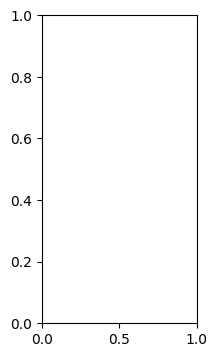

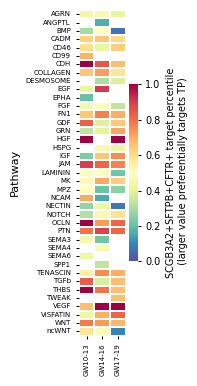

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(2.,4))

g = sns.heatmap(data=pathway_plot_df,
               cmap='Spectral_r',yticklabels=True, ax=ax, vmin=0, vmax=1, linewidth=0.1,
               cbar_kws={'label': 'SCGB3A2+SFTPB+CFTR+ target percentile\n (larger value preferentially targets TP)'
                       })

g.figure.axes[-1].yaxis.label.set_size(7)
g.figure.axes[-1].tick_params(labelsize=7, length=2, width=0.75)
g.tick_params(labelsize=5, length=2, width=0.75)
g.set_ylabel('Pathway', fontsize=8)
g.set_xlabel('', fontsize=8)
plt.tight_layout()
plt.savefig('figures/pathways_interaction_strength_all.pdf')
plt.show()

In [23]:
%%R

gg1 = netVisual_bubble(cellchat, targets.use = c('SCGB3A2hiSFTPBhiCFTRhi cells'),  
                 comparison = c(1,2,3),  remove.isolate=TRUE, max.dataset=1)
print(names(gg1))
write.csv(gg1$data, 'data/TP_LR_analysis_maxearly.csv')

gg1 = netVisual_bubble(cellchat, targets.use = c('SCGB3A2hiSFTPBhiCFTRhi cells'),  
                 comparison = c(1,2),  remove.isolate=TRUE, max.dataset=2)
print(names(gg1))
write.csv(gg1$data, 'data/TP_LR_analysis_maxmid.csv')

gg1 = netVisual_bubble(cellchat, targets.use = c('SCGB3A2hiSFTPBhiCFTRhi cells'),  
                 comparison = c(1,3),  remove.isolate=TRUE, max.dataset=3)
print(names(gg1))
write.csv(gg1$data, 'data/TP_LR_analysis_maxlate.csv')


R[write to console]: Comparing communications on a merged object 




 [1] "data"        "layers"      "scales"      "guides"      "mapping"    
 [6] "theme"       "coordinates" "facet"       "plot_env"    "layout"     
[11] "labels"     


R[write to console]: Comparing communications on a merged object 




 [1] "data"        "layers"      "scales"      "guides"      "mapping"    
 [6] "theme"       "coordinates" "facet"       "plot_env"    "layout"     
[11] "labels"     


R[write to console]: Comparing communications on a merged object 




 [1] "data"        "layers"      "scales"      "guides"      "mapping"    
 [6] "theme"       "coordinates" "facet"       "plot_env"    "layout"     
[11] "labels"     


In [24]:
import pandas as pd
LR_max_early = pd.read_csv('data/TP_LR_analysis_maxearly.csv', index_col=0)
LR_max_early['max_dataset'] = 'early'

LR_max_mid = pd.read_csv('data/TP_LR_analysis_maxmid.csv', index_col=0)
LR_max_mid['max_dataset'] = 'mid'

LR_max_late = pd.read_csv('data/TP_LR_analysis_maxlate.csv', index_col=0)
LR_max_late['max_dataset'] = 'late'


In [25]:
LR_combined = pd.concat([LR_max_early, LR_max_mid, LR_max_late])

In [26]:
celltype = []
for i in range(LR_combined.shape[0]):
    if LR_combined.source.values[i] in ['Lipofibroblasts', 'Lipofibroblast precursors',
                              'Early fibroblasts', 'Airway fibroblast progenitors',
                              'Unknown stromal cells', 'Airway SMC', 'Vascular SMC',
                              'Uncommitted cells', 'Chondrocyte']:
        celltype.append('Stromal')
    else:
        celltype.append('Epithelial')
LR_combined['Broad type'] = celltype

In [27]:
tp = []
for i in range(LR_combined.shape[0]):
    if LR_combined.iloc[i]['dataset']=='early':
        tp.append(0)
    elif LR_combined.iloc[i]['dataset']=='mid':
        tp.append(1)
    else:
        tp.append(2)
LR_combined['tp'] = tp

In [28]:
newdataset = []
for i in range(LR_combined.shape[0]):
    if LR_combined.iloc[i]['dataset']=='early':
        newdataset.append('GW10-13')
    elif LR_combined.iloc[i]['dataset']=='mid':
        newdataset.append('GW14-16')
    else:
        newdataset.append('GW17-19')
LR_combined['newdataset'] = newdataset

In [29]:
LR_combined.source

2302     Stromal-like cells 2
2191       Budtip progenitors
2196     Stromal-like cells 2
2197          SMG basal cells
4396       Budtip progenitors
                ...          
2654              Basal cells
2614    Mature ciliated cells
2644    Mature ciliated cells
2618    Mature ciliated cells
2648    Mature ciliated cells
Name: source, Length: 6631, dtype: object

<ipython-input-30-a8277f36670f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR['max_dataset'] = max_dataset
<ipython-input-30-a8277f36670f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR['col_title'] = LR['max_dataset'].replace({'early': 'Increased early',
<ipython-input-30-a8277f36670f>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

2470   -0.225331
4667   -0.196731
6084   -0.191921
2477   -0.129039
2478   -0.116999
          ...   
2494    0.121691
3924    0.127544
3925    0.143684
3926    0.142658
3927    0.141169
Name: signed_prob, Length: 64, dtype: float64
-0.225330867750242 0.198550604369221
[[<AxesSubplot:ylabel='interaction_name_2'>]
 [<AxesSubplot:ylabel='interaction_name_2'>]
 [<AxesSubplot:xlabel='newdataset', ylabel='interaction_name_2'>]]


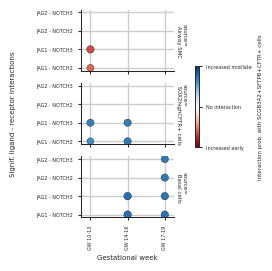

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.colors import TwoSlopeNorm

sns.set(style="ticks")

LR = LR_combined[LR_combined.pathway_name.isin(['NOTCH'])]

max_dataset=[]
for i in range(LR.shape[0]):
    if LR.max_dataset.values[i] == 'early':
        max_dataset.append('early')
    else:
        max_dataset.append('mid/late')
LR['max_dataset'] = max_dataset
LR['col_title'] = LR['max_dataset'].replace({'early': 'Increased early',
                                             'mid/late': 'Increased mid/late'})

LR = LR[~LR.source.isin(['PNEC', 'Mature ciliated cells',
                                           'Ciliated precursor cells',
                                          'SCGB3A2hiFOXJ1hi cells'])]

import seaborn as sns

cmap = sns.color_palette("Spectral_r", as_cmap=True)
cmap = sns.color_palette("RdBu", as_cmap=True)

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    
    plt.scatter(x, y, c=c, s=np.abs(c) * 200, **kwargs) #**1
    
def facet_lines(x, y,  **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    #print(x,y.values)
    for lr in np.unique(y.values):
        x_ = x[y==lr]
        y_ = y[y==lr]
        plt.plot(x_, y_, color='grey', linewidth=0.5, **kwargs)

        

LR['signed_prob'] = LR.apply(lambda x: -1*x['prob'] if x['col_title']=='Increased early' else x['prob'], axis=1)
     
print(LR['signed_prob'])

vmin, vmax = LR.signed_prob.min(), LR.signed_prob.max()
print(vmin, vmax)

norm = TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

LR[LR.source.isin(source_celltypes)].sort_values('tp').to_csv('data/NOTCH_LR.csv')

g = sns.FacetGrid(data=LR[LR.source.isin(source_celltypes)].sort_values('tp'), 
                  margin_titles=True, height=0.9,row='source', aspect=1.3, #col_wrap=2,
                  sharex=True, sharey=True)#, #sharey='row',row='col_title',
                 #gridspec_kws=dict(height_ratios=(5.0/8.0, 1.0)))#, size=1)#, size='pval')#, size='pval')
g.map(facet_scatter, "newdataset", "interaction_name_2", "signed_prob", #s=10,
               cmap=cmap,edgecolor="black",linewidth=0.22,norm=norm) #.add_legend()#, size='pval'))

g.set_titles(row_template = 'source=\n {row_name}', col_template = 'source =\n {col_name}', size=4)


g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([1.1, .37, .03, .3])

points = plt.scatter([], [], c=[], cmap=cmap,norm=norm)


print(g.axes)

# Draw the colorbar
cbar = g.fig.colorbar(points, cax=cax)
cbar.outline.set_linewidth(0.7)

cax.set_yticklabels(['Increased early','No interaction', 'Increased mid/late'])
cax.tick_params(labelsize=3.5,length=2., width=0.75)
cax.set_yticks([vmin, 0, vmax])#.tick_params(labelsize=0)
cax.set_ylabel('Interaction prob. with SCGB3A2+SFTPB+CFTR+ cells', fontsize=4)
for ax in g.axes.flatten():
    ax.tick_params(labelsize=3.5,length=2., width=0.75)
    ax.set_xticks([0,1,2])#,rotation=90)
    ax.set_xticklabels(labels=['GW 10-13', 'GW 14-16', 'GW 17-19'],rotation=90)

for ax in g.axes.flatten():
    ax.grid()  
    ax.set_xlim(-0.25,2.25)
    ax.set_ylabel('', fontsize=8)
    ax.set_xlabel('', fontsize=8)

for ax in g.axes.flatten():
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)

g.axes.flatten()[2].set_xlabel('Gestational week', fontsize=5)

g.axes.flatten()[0].set_ylabel('Signif. ligand - receptor interactions', fontsize=5)
g.axes.flatten()[0].yaxis.set_label_coords(-0.7,-0.7)
plt.tight_layout()
g.savefig('figures/LR_dotplot_TP_target_NOTCH_rotated.pdf')
plt.show()

<ipython-input-31-0d61a73739c7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR['max_dataset'] = max_dataset
<ipython-input-31-0d61a73739c7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR['col_title'] = LR['max_dataset'].replace({'early': 'Increased early',


114    -0.126668
116    -0.121104
220    -0.203602
221    -0.196030
222    -0.192701
          ...   
2640    0.133004
2611    0.120826
2641    0.128397
2612    0.125212
2642    0.133360
Name: signed_prob, Length: 361, dtype: float64
-0.203601824356334 0.209147545931547


/home/spencer/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
<ipython-input-31-0d61a73739c7>:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(['Increased early','No interaction', 'Increased mid/late'])
<ipython-input-31-0d61a73739c7>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['GW 10-13', 'GW 14-16', 'GW 17-19'],rotation=90)
<ipython-input-31-0d61a73739c7>:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[<AxesSubplot:title={'center':'source =\n Airway SMC'}, ylabel='interaction_name_2'>
 <AxesSubplot:title={'center':'source =\n Lipofibroblast precursors'}>
 <AxesSubplot:title={'center':'source =\n Airway fibroblast progenitors'}, xlabel='newdataset', ylabel='interaction_name_2'>
 <AxesSubplot:title={'center':'source =\n Basal cells'}, xlabel='newdataset'>]
[<AxesSubplot:title={'center':'source =\n Airway SMC'}, ylabel='interaction_name_2'>
 <AxesSubplot:title={'center':'source =\n Lipofibroblast precursors'}>
 <AxesSubplot:title={'center':'source =\n Airway fibroblast progenitors'}, xlabel='newdataset', ylabel='interaction_name_2'>
 <AxesSubplot:title={'center':'source =\n Basal cells'}, xlabel='newdataset'>]


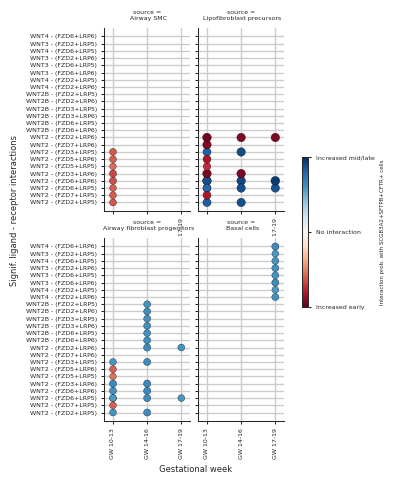

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.colors import TwoSlopeNorm

sns.set(style="ticks")

LR = LR_combined[LR_combined.pathway_name.isin(['WNT'])]


max_dataset=[]
for i in range(LR.shape[0]):
    if LR.max_dataset.values[i] == 'early':
        max_dataset.append('early')
    else:
        max_dataset.append('mid/late')
LR['max_dataset'] = max_dataset
LR['col_title'] = LR['max_dataset'].replace({'early': 'Increased early',
                                             'mid/late': 'Increased mid/late'})

LR = LR[~LR.source.isin(['PNEC', 'Mature ciliated cells',
                                           'Ciliated precursor cells',
                                          'SCGB3A2hiFOXJ1hi cells'])]

import seaborn as sns

cmap = sns.color_palette("Spectral_r", as_cmap=True)
cmap = sns.color_palette("RdBu", as_cmap=True)

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    
    plt.scatter(x, y, c=c, s=np.abs(c) * 200, **kwargs) #**1
    
def facet_lines(x, y,  **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    #print(x,y.values)
    for lr in np.unique(y.values):
        x_ = x[y==lr]
        y_ = y[y==lr]
        plt.plot(x_, y_, color='grey', linewidth=0.5, **kwargs)

LR['signed_prob'] = LR.apply(lambda x: -1*x['prob'] if x['col_title']=='Increased early' else x['prob'], axis=1)
     
print(LR['signed_prob'])

vmin, vmax = LR.signed_prob.min(), LR.signed_prob.max()
print(vmin, vmax)

norm = TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

LR[LR.source.isin(source_celltypes)].sort_values('tp').to_csv('data/WNT_LR.csv')

g = sns.FacetGrid(data=LR[LR.source.isin(source_celltypes)].sort_values('tp'), 
                  margin_titles=True, height=2.5 ,col='source',  aspect=0.6, col_wrap=2,
                  sharex=True)
g.map(facet_scatter, "newdataset", "interaction_name_2", "signed_prob", 
               cmap=cmap,edgecolor="black",linewidth=0.22,norm=norm) 

g.set_titles(row_template = 'source =\n {row_name}', col_template = 'source =\n {col_name}', size=4.5)

#g.set_titles()

g.fig.subplots_adjust(right=.92)

cax = g.fig.add_axes([1.0, .37, .02, .3])

points = plt.scatter([], [], c=[], cmap=cmap,norm=norm) 


print(g.axes)

# Draw the colorbar
cbar = g.fig.colorbar(points, cax=cax)#, size=5)#, labelsize=7)
cbar.outline.set_linewidth(0.7)


cax.set_yticklabels(['Increased early','No interaction', 'Increased mid/late'])
cax.tick_params(labelsize=4.5,length=2., width=0.75)
cax.set_yticks([vmin, 0, vmax])#.tick_params(labelsize=0)
cax.set_ylabel('Interaction prob. with SCGB3A2+SFTPB+CFTR+ cells', fontsize=4)
for ax in g.axes.flatten():
    ax.tick_params(labelsize=4.5,length=2., width=0.75)
    ax.set_xticklabels(labels=['GW 10-13', 'GW 14-16', 'GW 17-19'],rotation=90)
print(g.axes)
for ax in g.axes.flatten():
    ax.grid()  
    ax.set_xlim(-0.25,2.25)
    ax.set_ylabel('', fontsize=8)
    ax.set_xlabel('', fontsize=8)
g.axes.flatten()[2].set_xlabel('                                     Gestational week', fontsize=6)

for ax in g.axes.flatten():
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)

g.axes.flatten()[0].set_ylabel('Signif. ligand - receptor interactions', fontsize=6)
#g.axes.flatten()[1].set_ylabel('Signif. ligand - receptor interactions', fontsize=5)
g.axes.flatten()[0].yaxis.set_label_coords(-1,-0.0)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.15)
g.savefig('figures/LR_dotplot_TP_target_WNT_rotated.pdf')
plt.show()

<ipython-input-32-eff6d2b3fca4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR['max_dataset'] = max_dataset
<ipython-input-32-eff6d2b3fca4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR['col_title'] = LR['max_dataset'].replace({'early': 'Increased early',
/home/spencer/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **k

397    -0.117877
398    -0.124921
399    -0.111975
400    -0.105964
401    -0.136131
          ...   
416     0.139748
417     0.132229
2735    0.154360
2736    0.146314
2737    0.206493
Name: signed_prob, Length: 124, dtype: float64
-0.198905748396288 0.23479373694009
[[<AxesSubplot:title={'center':'source =\n Airway fibroblast progenitors'}, xlabel='newdataset', ylabel='interaction_name_2'>
  <AxesSubplot:title={'center':'source =\n Airway SMC'}, xlabel='newdataset'>]]
[[<AxesSubplot:title={'center':'source =\n Airway fibroblast progenitors'}, xlabel='newdataset', ylabel='interaction_name_2'>
  <AxesSubplot:title={'center':'source =\n Airway SMC'}, xlabel='newdataset'>]]


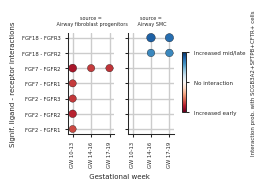

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.colors import TwoSlopeNorm

sns.set(style="ticks")

LR = LR_combined[LR_combined.pathway_name.isin(['FGF'])]

max_dataset=[]
for i in range(LR.shape[0]):
    if LR.max_dataset.values[i] == 'early':
        max_dataset.append('early')
    else:
        max_dataset.append('mid/late')
LR['max_dataset'] = max_dataset
LR['col_title'] = LR['max_dataset'].replace({'early': 'Increased early',
                                             'mid/late': 'Increased mid/late'})

LR = LR[~LR.source.isin(['PNEC', 'Mature ciliated cells',
                                           'Ciliated precursor cells',
                                          'SCGB3A2hiFOXJ1hi cells'])]

import seaborn as sns

cmap = sns.color_palette("Spectral_r", as_cmap=True)
cmap = sns.color_palette("RdBu", as_cmap=True)
#cmap = sns.diverging_palette(220, 20, as_cmap=True)

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    
    plt.scatter(x, y, c=c, s=np.abs(c) * 200, **kwargs) #**1
    
def facet_lines(x, y,  **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    for lr in np.unique(y.values):
        x_ = x[y==lr]
        y_ = y[y==lr]
        plt.plot(x_, y_, color='grey', linewidth=0.5, **kwargs)

LR['signed_prob'] = LR.apply(lambda x: -1*x['prob'] if x['col_title']=='Increased early' else x['prob'], axis=1)
     
print(LR['signed_prob'])


vmin, vmax = LR.signed_prob.min(), LR.signed_prob.max()
print(vmin, vmax)

norm = TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

LR[LR.source.isin(source_celltypes)].sort_values('tp').to_csv('data/FGF_LR.csv')

g = sns.FacetGrid(data=LR[LR.source.isin( source_celltypes)].sort_values('tp'), 
                  margin_titles=True, height=2. ,col='source', aspect=0.5, 
                  sharex=True)#, #sharey='row',row='col_title',
                 #gridspec_kws=dict(height_ratios=(5.0/8.0, 1.0)))#, size=1)#, size='pval')#, size='pval')
g.map(facet_scatter, "newdataset", "interaction_name_2", "signed_prob", #s=10,
               cmap=cmap,edgecolor="black",linewidth=0.22,norm=norm) #.add_legend()#, size='pval')

g.set_titles(row_template = '{row_name}', col_template = 'source =\n {col_name}', size=3.5)


g.fig.subplots_adjust(right=.92)

cax = g.fig.add_axes([0.95, .425, .02, .3])

points = plt.scatter([], [], c=[], cmap=cmap,norm=norm) 


print(g.axes)

# Draw the colorbar
cbar=g.fig.colorbar(points, cax=cax)#, size=5)#, labelsize=7)
cbar.outline.set_linewidth(0.7)

cax.set_yticklabels(['Increased early','No interaction', 'Increased mid/late'])
cax.tick_params(labelsize=4., length=2, width=0.75)
cax.set_yticks([vmin, 0, vmax])#.tick_params(labelsize=0)
cax.set_ylabel('Interaction prob. with SCGB3A2+SFTPB+CFTR+ cells', fontsize=4)
for ax in g.axes.flatten():
    ax.tick_params(labelsize=3.775,length=2., width=0.75)
    ax.set_xticklabels(labels=['GW 10-13', 'GW 14-16', 'GW 17-19'],rotation=90)
print(g.axes)
for ax in g.axes.flatten():
    ax.grid()  
    ax.set_xlim(-0.25,2.25)
    ax.set_ylabel('', fontsize=8)
    ax.set_xlabel('', fontsize=8)
g.axes.flatten()[0].set_xlabel('                         Gestational week', fontsize=5)

for ax in g.axes.flatten():
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)

g.axes.flatten()[0].set_ylabel('Signif. ligand - receptor interactions', fontsize=5)
#g.axes.flatten()[0].yaxis.set_label_coords(-0.8,-0.3)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.1)
g.savefig('figures/LR_dotplot_TP_target_FGF.pdf')
plt.show()

In [30]:
%%R 
df.net <- subsetCommunication(cellchat, target='SCGB3A2hiSFTPBhiCFTRhi cells')

write.csv(df.net$early, "data/merged_communication_early_all.csv")
write.csv(df.net$mid, "data/merged_communication_mid_all.csv")
write.csv(df.net$late, "data/merged_communication_late_all.csv")

In [31]:
import pandas as pd
import numpy as np

df_early = pd.read_csv("data/merged_communication_early_all.csv", index_col=0)
df_mid = pd.read_csv("data/merged_communication_mid_all.csv", index_col=0)
df_late = pd.read_csv("data/merged_communication_late_all.csv", index_col=0)

In [32]:
df_early['Timepoint'] = 'GW10-13'
df_mid['Timepoint'] = 'GW14-16'
df_late['Timepoint'] = 'GW17-19'

df_early['tp'] = 0
df_mid['tp'] = 1
df_late['tp'] = 2

In [33]:
merged = pd.concat([df_early, df_mid, df_late])

In [34]:
merged = merged[merged.pathway_name=='FGF']

In [35]:
flow_merged = merged.groupby(['source', 'Timepoint', 'tp'])['prob'].sum()

In [36]:
flow_merged = flow_merged.reset_index()
flow_merged = flow_merged.sort_values('tp')
flow_merged

,source,Timepoint,tp,prob
8,Chondrocyte,GW10-13,0,0.003067
15,Early fibroblasts,GW10-13,0,0.002200
21,Proliferating progenitors,GW10-13,0,0.003544
12,Early AT2-like cells,GW10-13,0,0.002680
11,Cycling fibroblasts,GW10-13,0,0.001966
24,SMG basal cells,GW10-13,0,0.012179
18,Lipofibroblasts,GW10-13,0,0.002239
5,Budtip progenitors,GW10-13,0,0.022523
30,Stromal-like cells 2,GW10-13,0,0.000617
2,Airway fibroblast progenitors,GW10-13,0,0.005809


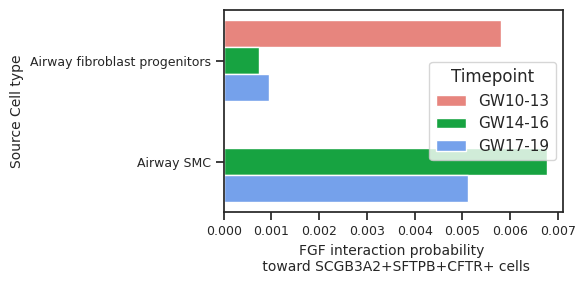

In [41]:
import seaborn as sns 
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(6,3))

flow_merged[flow_merged.source.isin(source_celltypes)].to_csv('data/FGF_interaction_prob.csv')

g=sns.barplot(data=flow_merged[flow_merged.source.isin(source_celltypes)], 
               x='prob', y='source',
               hue='Timepoint', palette=["#f8766d", "#00BA38", "#619CFF"],
               alpha=1)#palette='Set2')#, stacked=True)
#g.set_xlim(0,1.05)
g.set_xlabel('FGF interaction probability \n toward SCGB3A2+SFTPB+CFTR+ cells', fontsize=10)
g.set_ylabel('Source Cell type', fontsize=10)

sns.move_legend(ax, "center right")#, bbox_to_anchor=(0.65, 0.7))

#plt.xticks(rotation=90)

#for ax in g.axes.flatten():
g.axes.tick_params(labelbottom=True, labelsize=9)
plt.tight_layout()
plt.savefig('figures/FGF_information_flow.pdf')
plt.show()